In [1]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4149 sha256=5ea88ee1a790b16899025b20664e83d491b177fc46b955e2eeed894654c9ead2
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Nov 21 15:04:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from typing import *
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary
import torch.utils.data as data
import random
import copy
from google.colab import files
# from tensorflow.keras.layers import GlobalAveragePooling2D

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is set to {device}.")

Device is set to cuda.


In [4]:
random_seed = 42

def transformer() -> transforms:
  """
  this function normalizes data for better convergence.
  it normalizes with the mean and std of each channel(R, G, and B)
  meand and std values obtained 
  from https://www.kaggle.com/code/fanbyprinciple/cifar10-explanation-with-pytorch
  return: transform object 
  """

  normalize = transforms.Normalize(
      mean=[0.4914, 0.4822, 0.4465],
      std=[0.2023, 0.1994, 0.2010])
  # define transforms
  transform = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      normalize])
  return transform

def train_loader(data_dir: str, batch_size: float, valid_size=0.9) -> List[DataLoader]:
  """
  data_dir: dir to load data from
  batch_size: dataset batch size
  valid_size: to produce the validation set
  This function normalized the train data and return train and validation datasets
  """

  # normalizing data 
  transform =  transformer()

  # load the dataset
  train_dataset = datasets.CIFAR10(
      root=data_dir, train=True, download=True, transform=transform)

  valid_dataset = datasets.CIFAR10(
      root=data_dir, train=True, download=True, transform=transform)

  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))
  np.random.seed(random_seed)
  np.random.shuffle(indices)

  train_idx, valid_idx = indices[:split], indices[split:]
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)

  train_loader = DataLoader(
      train_dataset, batch_size=batch_size, sampler=train_sampler)

  valid_loader = DataLoader(
      valid_dataset, batch_size=batch_size, sampler=valid_sampler)

  return [train_loader, valid_loader]

def test_loader(data_dir: str, batch_size: float) -> DataLoader:
  """
  data_dir: dir to load data from
  batch_size: dataset batch size
  valid_size: to produce the validation set
  This function normalized the test data and return test dataset
  """
  # normalizing data 
  transform =  transformer()

  # load the dataset
  
  dataset = datasets.CIFAR10(
      root=data_dir, train=False, download=True, transform=transform)
  
  data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=batch_size, shuffle=True)

  return data_loader


In [5]:
# train & validation data loader obj
loader = train_loader(data_dir='./data', batch_size=64)
train_data_loader, valid_data_loader = loader[0], loader[1]
# test data loader obj
test_data_loader = test_loader(data_dir='./data', batch_size=64)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(f"size of training data: {len(train_data_loader)},\n" \
      f"size of validation data: {len(valid_data_loader)},\n"\
      f"size of test data: {len(test_data_loader)}\n")

size of training data: 704,
size of validation data: 79,
size of test data: 157



In [20]:
### Lets take a look at the predefined ResNet34 in torch
pre_defined_model = models.resnet34()
print(pre_defined_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# residual block
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
    """
    in_channels: number of input channels
    out_channels: number of output channels
    stride: 
    downsample: skip connection 
    This function builds the ResidualBlock that we can re-use through out the network.
    """
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels, 
                  out_channels, 
                  stride = stride,
                  kernel_size = 3, 
                  padding = 1),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU())
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, 
                  out_channels, 
                  kernel_size = 3, 
                  stride = 1, 
                  padding = 1),
                  nn.BatchNorm2d(out_channels))
    self.downsample = downsample
    self.relu = nn.ReLU()
    self.out_channels = out_channels
  
  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.conv2(out)
    if self.downsample:
        residual = self.downsample(x)
    out += residual
    out = self.relu(out)
    return out

In [8]:
class ResNet(nn.Module):
  """
  This function builds a ResNet34
  """
  def __init__(self, block, layers, num_classes = 10):
      super(ResNet, self).__init__()
      self.inplanes = 64
      self.conv1 = nn.Sequential(
                      nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                      nn.BatchNorm2d(64),
                      nn.ReLU())
      self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
      self.layer0 = self.make_layer(block, 128, layers[0], stride = 1)
      self.layer1 = self.make_layer(block, 64, layers[1], stride = 2)
      self.layer2 = self.make_layer(block, 64, layers[2], stride = 2)
      self.layer3 = self.make_layer(block, 256, layers[3], stride = 2)
      self.avgpool = nn.AvgPool2d(7, stride=1)
      self.fc = nn.Linear(256, num_classes)
      
  def make_layer(self, block, planes, blocks, stride=1):
    """
    The function adds the layers one by one along with the Residual Block. 
    After the blocks, we add the average pooling and the final linear layer.
    """
    downsample = None
    if stride != 1 or self.inplanes != planes:
        
        downsample = nn.Sequential(
            nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
            nn.BatchNorm2d(planes),
        )
    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes
    for i in range(1, blocks):
        layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)
  
  
  def forward(self, x):
      x = self.conv1(x)
      x = self.maxpool(x)
      x = self.layer0(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)

      x = self.avgpool(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)

      return x

In [9]:
num_classes = 10
num_epochs = 50
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

In [10]:
print(f"Number of trainable pars: {sum([param.nelement() for param in model.parameters()])}")

Number of trainable pars: 4743050


In [11]:
img,label =  next(iter(train_data_loader))
input_size = list(img.shape)
summary(model,(input_size[1], input_size[2], input_size[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,584
       BatchNorm2d-9          [-1, 128, 56, 56]             256
           Conv2d-10          [-1, 128, 56, 56]           8,320
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
    ResidualBlock-13          [-1, 128, 56, 56]               0
           Conv2d-14          [-1, 128,

In [19]:
from torchviz import make_dot
yhat = model(img.to(device)) # Give dummy batch to forward().
make_dot(yhat, params=dict(list(model.named_parameters()))).render("restnet_torchviz", format="png")
files.download("restnet_torchviz.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import gc

train_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_data_loader):  
      # Move tensors to the configured device
      images = images.to(device)
      labels = labels.to(device)
      
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      del images, labels, outputs
      torch.cuda.empty_cache()
      gc.collect()
  
  train_loss_list.append(round(loss.item(),2))
  print (f"Epoch {epoch+1}/{num_epochs}, Train loss: {round(loss.item(),2)}")
          
  # Validation
  with torch.no_grad():
      correct = 0
      total = 0
      n_img = 0
      for images, labels in valid_data_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          n_img += 1
          correct += (predicted == labels).sum().item()
          del images, labels, outputs
      val_acc_list.append(100 * correct / total)
  
      print(f"Accuracy of the RestNet34 on the validation image set: {100 * correct / total}%") 

Epoch 1/50, Train loss: 1.86
Accuracy of the RestNet34 on the validation image set: 55.56%
Epoch 2/50, Train loss: 0.66
Accuracy of the RestNet34 on the validation image set: 70.26%
Epoch 3/50, Train loss: 0.42
Accuracy of the RestNet34 on the validation image set: 74.62%
Epoch 4/50, Train loss: 0.09
Accuracy of the RestNet34 on the validation image set: 76.18%
Epoch 5/50, Train loss: 0.3
Accuracy of the RestNet34 on the validation image set: 79.34%
Epoch 6/50, Train loss: 0.87
Accuracy of the RestNet34 on the validation image set: 80.14%
Epoch 7/50, Train loss: 0.46
Accuracy of the RestNet34 on the validation image set: 81.78%
Epoch 8/50, Train loss: 0.6
Accuracy of the RestNet34 on the validation image set: 80.16%
Epoch 9/50, Train loss: 0.22
Accuracy of the RestNet34 on the validation image set: 81.42%
Epoch 10/50, Train loss: 0.09
Accuracy of the RestNet34 on the validation image set: 81.46%
Epoch 11/50, Train loss: 0.7
Accuracy of the RestNet34 on the validation image set: 80.54%


In [14]:
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_data_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    # del images, labels, outputs

  print(f"Accuracy of the RestNet34 on the test image set: {100 * correct / total}%")   

Accuracy of the RestNet34 on the test image set: 81.73%


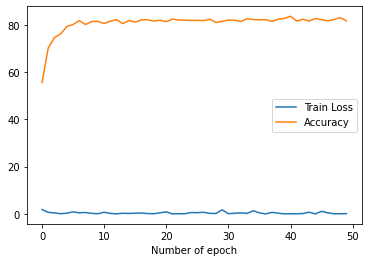

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
x = range(num_epochs)
plt.plot(x,train_loss_list, label = "Train Loss")
plt.xlabel("Number of epoch")
plt.plot(x,val_acc_list, label = "Accuracy")
plt.legend()
plt.show()
plt.savefig("acc_loss.png")
files.download("acc_loss.png")